<a href="https://colab.research.google.com/github/OoiXinPeng/Face-Mask-Recognition/blob/main/Face_Mask_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
# /gdrive/MyDrive/Colab Notebooks/SC project/FaceMask Dataset

## Step 1: Data preprocessing

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import PIL
import PIL.Image

In [ ]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

In [ ]:
main_folder_path = '/gdrive/MyDrive/Colab Notebooks/SC project/FaceMask Dataset/'
data_purposes = os.listdir(main_folder_path)
data_purposes = sorted(data_purposes)

classes = os.listdir(os.path.join(main_folder_path,data_purposes[0]))
classes = sorted(classes)

labels_dict = {classes[i]:i for i in range(len(classes))}

print(data_purposes)
print(classes)
print(labels_dict)

['Test', 'Train', 'Validation']
['Mask', 'Mask_Chin', 'Mask_Mouth_Chin', 'Mask_Nose_Mouth', 'Without_Mask']
{'Mask': 0, 'Mask_Chin': 1, 'Mask_Mouth_Chin': 2, 'Mask_Nose_Mouth': 3, 'Without_Mask': 4}


In [ ]:
image_size = 224
save_path = '/gdrive/MyDrive/Colab Notebooks/SC project/save_folder'
# data_file_name = 'data' + '_' + data_purpose + '.npy'
# labels_file_name = 'labels' + '_' + data_purpose + '.npy'
# os.path.join(save_path,data_file_name), data
# os.path.join(save_path,labels_file_name), labels

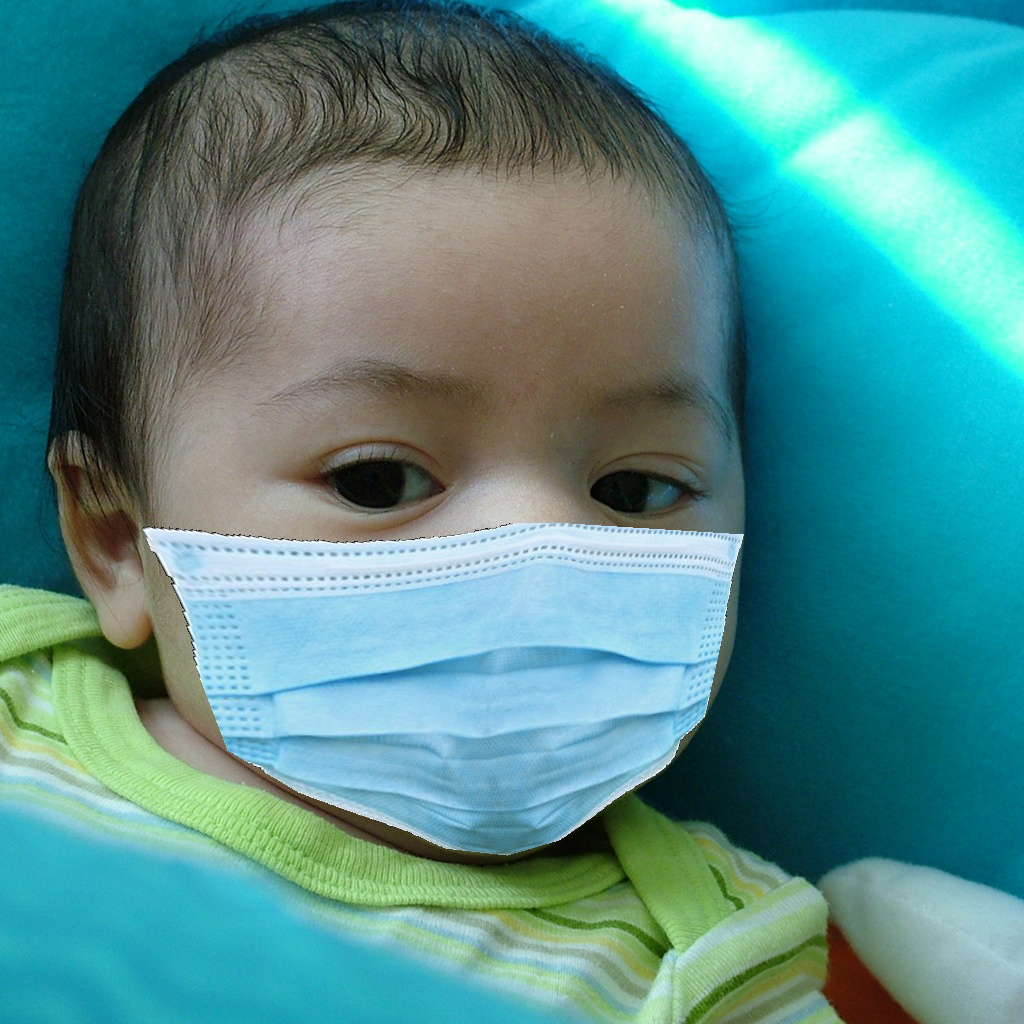

In [ ]:
# show sample image
PIL.Image.open('/gdrive/MyDrive/Colab Notebooks/SC project/FaceMask Dataset/Train/Mask/00000_Mask.jpg')

Skip this cell if image array has been saved before.

In [ ]:
for data_purpose in data_purposes:
  data_purpose_folder_path = os.path.join(main_folder_path,data_purpose)
  data = []
  labels = []
  for clas in classes:
    class_folder_path = os.path.join(data_purpose_folder_path,clas)
    image_names = os.listdir(class_folder_path)

    for image_name in image_names:
      image_path = os.path.join(class_folder_path,image_name)
      # Load the image and resize it
      image = load_img(image_path, target_size=(image_size, image_size))
      # Convert image to array
      image = img_to_array(image)
      # Scale the pixel intensities of image to the range [-1, 1] as small values are better for NN
      image = preprocess_input(image)
      data.append(image)
    labels.extend([labels_dict[clas]]*len(image_names))
  
  # Convert the data and labels list to NumPy arrays
  data = np.array(data, dtype="float32")
  labels = np.array(labels)
    
  data_file_name = 'data' + '_' + data_purpose + '.npy'
  labels_file_name = 'labels' + '_' + data_purpose + '.npy'
    
  # Save NumPy arrays as files to be reused
  np.save(os.path.join(save_path,data_file_name), data)
  np.save(os.path.join(save_path,labels_file_name), labels)
  print(data_file_name , 'done')

KeyboardInterrupt: ignored

## Step 2: Traning the model 

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers #,callbacks
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report

In [ ]:
# Load preprocessed data
# save_folder_dir = sorted(os.listdir(save_path))
numpy_files = sorted([f for f in os.listdir(save_path) if f.endswith('.npy')])

test_X = np.load(os.path.join(save_path,numpy_files[0]))
train_X = np.load(os.path.join(save_path,numpy_files[1]))
valid_X = np.load(os.path.join(save_path,numpy_files[2]))
test_y = np.load(os.path.join(save_path,numpy_files[3]))
train_y = np.load(os.path.join(save_path,numpy_files[4]))
valid_y = np.load(os.path.join(save_path,numpy_files[5]))

In [ ]:
# Check X,y shape
print(train_X.shape)
print(train_y.shape)
print(valid_X.shape)
print(valid_y.shape)
print(test_X.shape)
print(test_y.shape)

(1730, 224, 224, 3)
(1730,)
(568, 224, 224, 3)
(568,)
(580, 224, 224, 3)
(580,)


In [ ]:
##Handle imbalance classes #1
#from imblearn.over_sampling import SMOTE

#smote = SMOTE('minority')
#train_X_sm, train_y_sm = smote.fit_sample(train_X,train_y)
#valid_X_sm, valid_y_sm = smote.fit_sample(valid_X,valid_y)

In [ ]:
##Handle imbalance classes #2 
#from sklearn.utils import class_weight
#class_weight = class_weight.compute_class_weight('balanced', np.unique(train_y), train_y)

In [ ]:
# Apply one-hot encoding on labels
train_y = to_categorical(train_y)
valid_y = to_categorical(valid_y)
test_y = to_categorical(test_y)

In [ ]:
# Check y shape
print(train_y.shape)
print(valid_y.shape)
print(test_y.shape)

(1730, 5)
(568, 5)
(580, 5)


In [ ]:
# Setup plotting
import matplotlib.pyplot as plt

plt.style.use('seaborn-whitegrid')
# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)

In [ ]:
# Setup pretrained model VGG16
input_shape = train_X[0].shape
pretrained_model = tf.keras.applications.VGG16(
    weights='imagenet',
    include_top=False ,
    input_shape=input_shape
)
pretrained_model.trainable = False

In [ ]:
# Build model

model = keras.Sequential([
    pretrained_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(len(classes), activation='softmax'),
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 5)                 2565      
Total params: 14,717,253
Trainable params: 2,565
Non-trainable params: 14,714,688
_________________________________________________________________
None


Epoch 1/100
28/28 - 31s - loss: 1.2853 - accuracy: 0.5376 - val_loss: 1.1422 - val_accuracy: 0.6849
Epoch 2/100
28/28 - 9s - loss: 1.0786 - accuracy: 0.7092 - val_loss: 1.0244 - val_accuracy: 0.7148
Epoch 3/100
28/28 - 9s - loss: 0.9714 - accuracy: 0.7376 - val_loss: 0.9286 - val_accuracy: 0.7817
Epoch 4/100
28/28 - 9s - loss: 0.8869 - accuracy: 0.8052 - val_loss: 0.8515 - val_accuracy: 0.7993
Epoch 5/100
28/28 - 9s - loss: 0.8168 - accuracy: 0.8064 - val_loss: 0.7902 - val_accuracy: 0.8644
Epoch 6/100
28/28 - 9s - loss: 0.7572 - accuracy: 0.8694 - val_loss: 0.7359 - val_accuracy: 0.8521
Epoch 7/100
28/28 - 9s - loss: 0.7085 - accuracy: 0.8688 - val_loss: 0.6921 - val_accuracy: 0.8644
Epoch 8/100
28/28 - 9s - loss: 0.6658 - accuracy: 0.8798 - val_loss: 0.6511 - val_accuracy: 0.8891
Epoch 9/100
28/28 - 9s - loss: 0.6287 - accuracy: 0.8855 - val_loss: 0.6174 - val_accuracy: 0.8908
Epoch 10/100
28/28 - 9s - loss: 0.5951 - accuracy: 0.8890 - val_loss: 0.5866 - val_accuracy: 0.9032
Epoch 11

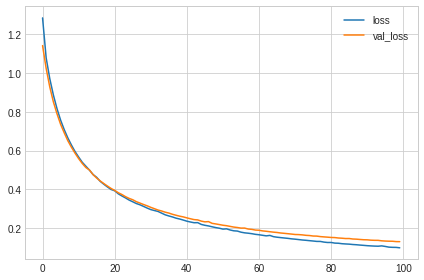

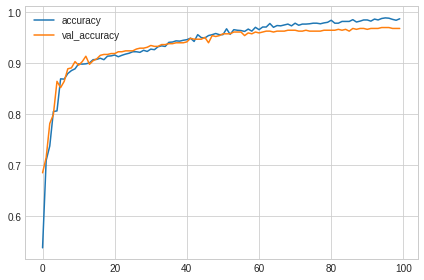

In [ ]:
# fit model
history = model.fit(
    train_X, train_y,            
    validation_data=(valid_X, valid_y),
    batch_size= 64, 
    epochs= 100,
    #class_weight = class_weight,
    verbose=2,
)

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot();
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()
print("Minimum Validation Loss: {}".format(history_df['val_loss'].min()))
print("Maximum Validation Accuracy: {}".format(history_df['val_accuracy'].max()))

In [ ]:
# Evaluate the model using test data
print(model.evaluate(test_X,test_y))

19/19 [==============================] - 10s 208ms/step - loss: 0.1637 - accuracy: 0.9586
[0.16368460655212402, 0.9586206674575806]


In [ ]:
# Calculate predict_y by model using test_X for further performance evaluation
from sklearn.metrics import confusion_matrix
predict_y = model.predict(test_X)

In [ ]:
predict_y_merge = np.argmax(predict_y,axis=1)
test_y_merge = np.argmax(test_y,axis=1)

In [ ]:
# Performance evaluation using classification_report
print(classification_report(test_y_merge, predict_y_merge, target_names=classes))

                 precision    recall  f1-score   support

           Mask       0.94      0.97      0.96       190
      Mask_Chin       1.00      0.50      0.67        12
Mask_Mouth_Chin       0.93      0.99      0.96       154
Mask_Nose_Mouth       0.93      0.58      0.72        24
   Without_Mask       0.99      0.99      0.99       200

       accuracy                           0.96       580
      macro avg       0.96      0.81      0.86       580
   weighted avg       0.96      0.96      0.96       580



In [ ]:
# Credit to https://www.kaggle.com/grfiv4/plot-a-confusion-matrix
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy


    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    #xlabel = 'Predicted label\n accuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\n accuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    #plt.xlabel(xlabel)
    plt.show()

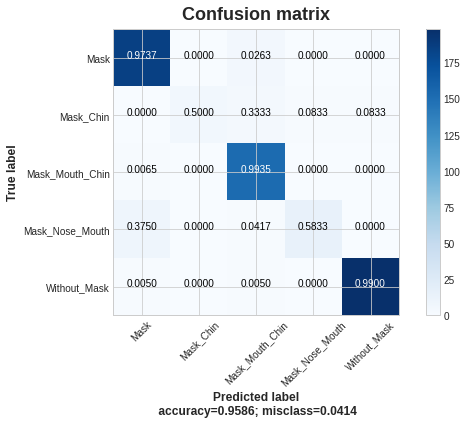

In [ ]:
# Visualise performance using confusion_matrix
cm = confusion_matrix(test_y_merge,predict_y_merge)
plot_confusion_matrix(
    cm=cm, 
    normalize=True,
    target_names= classes, 
    title='Confusion matrix',          
)

In [ ]:
# save the model
model.save(save_path)

INFO:tensorflow:Assets written to: /gdrive/MyDrive/Colab Notebooks/SC project/save_folder/assets


Step 3: Predict if an individual is wearing a face mask correctly or not or not wearing at all

In [ ]:
# load the model
model = keras.models.load_model(save_path)

In [ ]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 5)                 2565      
Total params: 14,717,253
Trainable params: 14,717,253
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
def perdict_custom_image(custom_image_path):
  image_size = 224
  image = load_img(custom_image_path, target_size=(image_size, image_size))
  image = img_to_array(image)
  image = preprocess_input(image)
  image = tf.expand_dims(image, 0) # Create a batch
  predictions = model.predict(image)
  score = predictions[0]
  print(
    "This image most likely belongs to {} class with a {:.2f} percent confidence."
    .format(classes[np.argmax(score)], 100 * np.max(score))
  )


In [ ]:
# predict the image sgown above
perdict_custom_image('/gdrive/MyDrive/Colab Notebooks/SC project/FaceMask Dataset/Train/Mask/00000_Mask.jpg')

This image most likely belongs to Mask with a 97.51 percent confidence.
